In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from shapely import geometry
from collections import OrderedDict
from IPython.display import SVG

In [2]:
#Script to compare the 2010 shapefile with the 2013_04 shapefile.
#Tests are performed to investigate whether there are PEILGEBIEDEN ID's with different polygon geometries

In [5]:
shape_2010 = r'P:\PR\4019.10\Werkmap\Werkmap_Joost\Shapefiles_FEWS/peilgebieden.shp'
shape_2013_04 = r'P:\PR\4019.10\Werkmap\Werkmap_Joost\Maandelijkse_Geodump_PG_AVG\Geodata_dump_2013_04\Peilgebieden_2013_04.shp'

In [6]:
gpd_2010 = gpd.read_file(shape_2010)
gpd_2013 = gpd.read_file(shape_2013_04)

In [7]:
#For each GPIDENT in 2010, look whether this ID is also present in 2013 and if so: compare geometry
x = 0
id_obj = []
for id_pg in gpd_2010['GPGIDENT'].values:
    id_equal = OrderedDict.fromkeys(['id_2010', 'in_2013_04','Equal','Overlap','Area_2010','Area_2013_04','perc_base','perc_update'])
    id_equal.update({'id_2010': id_pg})    
    if id_pg in gpd_2013['GPGIDENT'].values:
        id_equal.update({'in_2013_04': True})
 
        geom_2010     = gpd_2010[gpd_2010['GPGIDENT']==id_pg].reset_index()['geometry']
        geom_2013     = gpd_2013[gpd_2013['GPGIDENT']==id_pg].reset_index()['geometry']
        overlap_bool  = geom_2010.intersects(geom_2013).values[0]
        equal_bool    = (geom_2010.values == geom_2013.values)[0]
        
        geom_int      = geom_2010.intersection(geom_2013)
        opp_int       = geom_int.area
        opp_base      = geom_2010.area
        opp_update    = geom_2013.area
        perc_base     = opp_int / opp_base
        perc_update   = opp_int / opp_update   
        
        id_equal.update({'Equal': equal_bool})
        id_equal.update({'Overlap': overlap_bool})
        id_equal.update({'Area_2010': geom_2010.area[0]})
        id_equal.update({'Area_2013_04': geom_2013.area[0]})
        id_equal.update({'perc_base': perc_base[0]})
        id_equal.update({'perc_update': perc_update[0]})
        
        id_obj.append(id_equal)

df_compare = pd.DataFrame(id_obj)

c:\programdata\miniconda3\lib\site-packages\geopandas\base.py:29: UserWarning: GeoSeries crs mismatch: {} and {'proj': 'sterea', 'lat_0': 52.15616055555555, 'lon_0': 5.38763888888889, 'k': 0.9999079, 'x_0': 155000, 'y_0': 463000, 'ellps': 'bessel', 'units': 'm', 'no_defs': True}
  other.crs))


In [8]:
#df_compare dataframe column definition:

#id_2010:     GPGIDENT in 2010 shapefile
#in_2013_04:  Boolean to show if GPDIDENT as in 2010 also occurs in 2013
#Equal:       Boolean to show whether the polygons are Equal or not
#Overlap:     Boolean to show whether the polgyons in 2010 and 2013 have overlap
#Area_2010:   Area of the polygon in the 2010 shapefile
#Area_2013:   Area of the polygon in the 2013_04 shapefile
#perc_base:   Fraction of area of the intersection between the polygons relative to the 2010 polygon
#perc_update: Fraction of area of the intersection between the polygons relative to the 2013 polygon

df_compare.head()

,id_2010,in_2013_04,Equal,Overlap,Area_2010,Area_2013_04,perc_base,perc_update
0,PG0835,True,False,True,23849.278095,23849.300542,0.999999,0.999998
1,PG0807,True,False,True,1780.602760,1780.603562,0.999998,0.999998
2,PG0808,True,False,True,2726.953134,2726.962589,1.000000,0.999997
3,PG0809,True,False,True,2524.022559,2524.022603,0.999999,0.999999
4,PG0810,True,False,True,1059.779291,1059.777225,0.999993,0.999995


In [9]:
#Now extract the records which have an id which is present in 2013_04, but are not equal nor have overlap
df_subset = df_compare[df_compare['in_2013_04'] == True]
df_subset = df_subset[df_subset['Equal'] == False]
df_subset = df_subset[df_subset['Overlap'] == False]

In [31]:
df_overlap = df_compare[df_compare['Overlap'] == True]
n_overlap_significant = sum((df_overlap['perc_base'].values > 0.80) & (df_overlap['perc_update'].values >= 0.80))
n_overlap_niet_significant = sum((df_overlap['perc_base'].values < 0.80) | (df_overlap['perc_update'].values < 0.80))
n_no_overlap = len(df_subset)

print('Number of records in 2010:                                                 {}'.format(len(gpd_2010)))
print('Number of records in 2013:                                                 {}'.format(len(gpd_2013)))
print('Number of records with GPGIDENT occuring in both 2010 and 2013:            {}'.format(len(df_compare)))
print('Number of records with same ID which have significant overlap (>= 0.80):   {}'.format(n_overlap_significant))
print('Number of records with same ID which have no significant overlap (< 0.80): {}'.format(n_overlap_niet_significant))
print('Number of records with same ID but no overlap:                             {}'.format(n_no_overlap))

Number of records in 2010:                                                 902
Number of records in 2013:                                                 1297
Number of records with GPGIDENT occuring in both 2010 and 2013:            896
Number of records with same ID which have significant overlap (>= 0.80):   827
Number of records with same ID which have no significant overlap (< 0.80): 53
Number of records with same ID but no overlap:                             16


In [30]:
df_subset.head()

,id_2010,in_2013_04,Equal,Overlap,Area_2010,Area_2013_04,perc_base,perc_update
25,PG0768,True,False,False,62929.360963,54676.308998,0.0,0.0
34,PG0671,True,False,False,13515.711492,1860.935052,0.0,0.0
53,PG0607,True,False,False,7283.450827,9994.667094,0.0,0.0
105,PG0198,True,False,False,12679.527477,12300.892957,0.0,0.0
120,PG0869,True,False,False,20153.113857,27207.965695,0.0,0.0


In [36]:
id_compare

'PG0768'

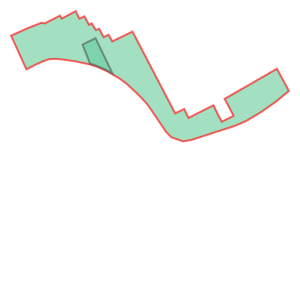

In [39]:
#Plot the polygons which have same ID in 2010 and 2013 but do not overlap
ids_compare = df_subset['id_2010'].values
id_compare = 'PG0194'#ids_compare[48]
g1 = gpd_2010[gpd_2010['GPGIDENT']==id_compare].iloc[0]['geometry']
g2 = gpd_2013[gpd_2013['GPGIDENT']==id_compare].iloc[0]['geometry']

svg_string = geometry.GeometryCollection([g1, g2])._repr_svg_()
svg_string = svg_string.replace('stroke="#555555"', 'stroke="red"', 1)
svg_string = svg_string.replace('fill="#ff3333"', 'fill="red"', 1)
SVG(svg_string)

In [33]:
df_overlap[(df_overlap['perc_base'].values < 0.80) | (df_overlap['perc_update'].values < 0.80)]

,id_2010,in_2013_04,Equal,Overlap,Area_2010,Area_2013_04,perc_base,perc_update
48,PG0195,True,False,True,6.246168e+04,4.596116e+04,0.451917,0.614160
85,PG0130,True,False,True,1.110200e+05,1.497544e+05,0.975980,0.723540
89,PG0038,True,False,True,1.109172e+05,1.910050e+05,1.000000,0.580703
101,PG0193,True,False,True,1.104562e+06,1.363031e+04,0.009458,0.766437
102,PG0194,True,False,True,7.164376e+04,3.381351e+03,0.047197,1.000000
103,PG0196,True,False,True,9.631187e+04,2.933975e+04,0.170863,0.560881
104,PG0197,True,False,True,5.133464e+04,8.001889e+04,0.870789,0.558638
106,PG0199,True,False,True,1.093094e+05,1.307349e+05,0.792759,0.662838
108,PG0192,True,False,True,6.519758e+04,1.089394e+03,0.016709,1.000000
117,PG0208,True,False,True,2.883974e+04,5.202143e+04,0.999218,0.553948
